In [ ]:
import pandas as pd
import numpy as np
import os

# === FUNÇÕES DE DETECÇÃO DE EVENTOS EXTREMOS ===
def is_hot_extreme(row):
    return row['maxtempC'] > 35 or row['HeatIndexC'] > 40

def is_cold_extreme(row):
    return row['mintempC'] < -3 or row['WindChillC'] < -5

def is_rain_extreme(row):
    return row['precipMM'] > 35  # Novo limiar sugerido

def is_snow_extreme(row):
    return row['totalSnow_cm'] > 0

def is_uv_extreme(row):
    return row['uvIndex'] >= 8

# === CLASSIFICAÇÃO POR SCORE ===
def classifica_score(score):
    if score >= 80:
        return 'Excelente'
    elif score >= 70:
        return 'Muito Bom'
    elif score >= 60:
        return 'Bom'
    elif score >= 50:
        return 'Aceitável'
    else:
        return 'Marginal'

# === MARCA EVENTO EXTREMO NO DIA ===
def marcar_extremo(row):
    return (
        is_hot_extreme(row)
        or is_cold_extreme(row)
        or is_rain_extreme(row)
        or is_snow_extreme(row)
    )

# === SCORE DIÁRIO ===
def score_dia(row):
    # Se for dia extremo, score 0 (pode ajustar se quiser dar um peso diferente)
    if marcar_extremo(row):
        return 0
    ideal_temp = 1 if 20 <= row['maxtempC'] <= 28 else 0
    moderate_temp = 1 if 18 < row['maxtempC'] < 32 else 0
    comfort_temp = 0.7 * ideal_temp + 0.3 * moderate_temp
    comfort_hum = 1 if 30 <= row['humidity'] <= 80 else 0
    comfort_sun = 1 if row['sunHour'] >= 5 else 0
    comfort_precip = 1 if row['precipMM'] <= 20 else 0
    score = 100 * (0.6 * comfort_temp + 0.15 * comfort_hum + 0.15 * comfort_sun + 0.1 * comfort_precip)
    return score

def load_weather_data(folder_path, min_days=365):
    dfs = []
    arquivos_descartados = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, parse_dates=['date_time'])
            city_name = filename.split(',')[0].replace("+", " ")
            df['municipio'] = city_name

            num_dias = df['date_time'].nunique()
            periodo = df['date_time'].max() - df['date_time'].min()

            if num_dias >= min_days:
                dfs.append(df)
            else:
                arquivos_descartados.append((filename, num_dias, periodo.days))

    print("\nArquivos descartados (menos de", min_days, "dias de histórico):")
    for nome, dias, periodo in arquivos_descartados:
        print(f"{nome}: {dias} dias distintos, período coberto: {periodo} dias")

    if not dfs:
        print("Nenhum arquivo com histórico suficiente.")
        return pd.DataFrame()

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def formatar_numericos(df):
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].apply(lambda x: '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.'))
    return df


In [6]:
filePathClima = '..\\..\\Bases\\Clima\\worldWeatherApi\\'
df = load_weather_data(filePathClima)


Arquivos descartados (menos de 365 dias de histórico):


In [44]:

# Marcar eventos extremos e calcular score diário
df['evento_extremo'] = df.apply(marcar_extremo, axis=1)
df['score_dia'] = df.apply(score_dia, axis=1)
df['classificacao_dia'] = df['score_dia'].apply(classifica_score)
df['ano_mes'] = df['date_time'].dt.to_period('M')
df['ano'] = df['date_time'].dt.year

# Resumo por cidade e mês
resumo_mensal = df.groupby(['municipio', 'ano_mes']).agg(
    dias_bons = ('classificacao_dia', lambda x: (x.isin(['Excelente','Muito Bom','Bom'])).sum()),
    dias_aceitaveis = ('classificacao_dia', lambda x: (x == 'Aceitável').sum()),
    dias_marginais = ('classificacao_dia', lambda x: (x == 'Marginal').sum()),
    extremos = ('evento_extremo', 'sum'),
    media_score = ('score_dia', 'mean'),
    media_maxtemp = ('maxtempC', 'mean'),
    media_mintemp = ('mintempC', 'mean'),
    qtd_eventos_extremos = ('evento_extremo', 'sum')
).reset_index()

# Classificação do mês conforme média do score
resumo_mensal['classificacao_mes'] = resumo_mensal['media_score'].apply(classifica_score)



# Se quiser o resumo geral de cada cidade (tudo junto)
resumo_geral = df.groupby('municipio').agg(
    total_dias = ('classificacao_dia', 'count'),
    dias_bons = ('classificacao_dia', lambda x: (x.isin(['Excelente','Muito Bom','Bom'])).sum()),
    dias_aceitaveis = ('classificacao_dia', lambda x: (x == 'Aceitável').sum()),
    dias_marginais = ('classificacao_dia', lambda x: (x == 'Marginal').sum()),
    extremos = ('evento_extremo', 'sum'),
    media_score = ('score_dia', 'mean'),
    media_maxtemp = ('maxtempC', 'mean'),
    media_mintemp = ('mintempC', 'mean')
).reset_index()

resumo_geral['classificacao_geral'] = resumo_geral['media_score'].apply(classifica_score)


In [74]:
df

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,visibility,winddirDegree,windspeedKmph,location,municipio,evento_extremo,score_dia,classificacao_dia,ano_mes,ano
0,2024-06-30,24,15,0.0,9.0,4,27,01:51 AM,03:37 PM,06:09 AM,...,10,305,14,"Abrantes,Portugal",Abrantes,False,100.0,Excelente,2024-06,2024
1,2024-07-01,30,13,0.0,15.0,6,26,02:18 AM,04:50 PM,06:09 AM,...,7,320,11,"Abrantes,Portugal",Abrantes,False,58.0,Aceitável,2024-07,2024
2,2024-07-02,35,17,0.0,15.0,7,19,02:50 AM,06:04 PM,06:10 AM,...,10,234,11,"Abrantes,Portugal",Abrantes,False,40.0,Marginal,2024-07,2024
3,2024-07-03,34,17,0.0,15.0,6,12,03:29 AM,07:15 PM,06:10 AM,...,10,313,12,"Abrantes,Portugal",Abrantes,False,40.0,Marginal,2024-07,2024
4,2024-07-04,38,16,0.0,15.0,7,5,04:16 AM,08:20 PM,06:11 AM,...,10,273,9,"Abrantes,Portugal",Abrantes,True,0.0,Marginal,2024-07,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113089,2025-06-26,29,13,0.0,15.0,5,0,06:41 AM,10:37 PM,06:03 AM,...,8,187,7,"Vouzela,Portugal",Vouzela,False,58.0,Aceitável,2025-06,2025
113090,2025-06-27,34,17,0.0,15.0,6,7,07:56 AM,11:15 PM,06:03 AM,...,10,172,6,"Vouzela,Portugal",Vouzela,False,40.0,Marginal,2025-06,2025
113091,2025-06-28,37,20,0.0,15.0,7,15,09:10 AM,11:45 PM,06:04 AM,...,10,188,6,"Vouzela,Portugal",Vouzela,True,0.0,Marginal,2025-06,2025
113092,2025-06-29,42,23,0.0,14.0,7,22,10:20 AM,No moonset,06:04 AM,...,10,95,7,"Vouzela,Portugal",Vouzela,True,0.0,Marginal,2025-06,2025


In [45]:
resumo_geral_formatado = formatar_numericos(resumo_geral)

In [47]:
# Você pode salvar em CSV:
filePathResumo = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\resumo_clima_portugal.csv'
resumo_geral_formatado.to_csv(filePathResumo, index=False)

In [46]:
resumo_geral_formatado

,municipio,total_dias,dias_bons,dias_aceitaveis,dias_marginais,extremos,media_score,media_maxtemp,media_mintemp,classificacao_geral
0,Abrantes,"366,00","109,00","38,00","219,00","33,00","49,02","23,24","11,44",Marginal
1,Agueda,"366,00","154,00","31,00","181,00","13,00","58,70","21,64","11,26",Aceitável
2,Aguiar da Beira,"366,00","93,00","35,00","238,00","20,00","46,87","20,54","9,92",Marginal
3,Alandroal,"366,00","93,00","42,00","231,00","43,00","45,47","23,20","11,76",Marginal
4,Albergaria-a-Velha,"366,00","177,00","19,00","170,00","5,00","61,27","19,39","12,42",Bom
...,...,...,...,...,...,...,...,...,...,...
304,Vinhais,"366,00","81,00","36,00","249,00","9,00","46,80","19,38","7,80",Marginal
305,Viseu,"366,00","93,00","35,00","238,00","20,00","46,87","20,54","9,92",Marginal
306,Vizela,"366,00","112,00","36,00","218,00","17,00","51,26","20,90","10,56",Aceitável
307,Vouzela,"366,00","104,00","38,00","224,00","18,00","49,41","19,47","10,08",Marginal


In [50]:
filePathGeo = '..\\..\\Bases\\Geocoding\\portugalMunicipiosGeo.csv'
# Carrega o arquivo de coordenadas
geo = pd.read_csv(filePathGeo)

In [53]:
# Padroniza nomes para garantir o merge
resumo_geral_formatado['location_merge'] = resumo_geral_formatado['municipio'].str.lower().str.strip()
geo['Cidades_merge'] = geo['Cidades'].str.lower().str.strip()

# Junta pelo nome da cidade padronizado
ranking_geo = pd.merge(
    resumo_geral_formatado,
    geo,
    left_on='location_merge',
    right_on='Cidades_merge',
    how='inner'
)

# Seleciona só as 10 melhores cidades pelo score
top10 = ranking_geo.sort_values('media_score', ascending=False).head(20)

In [78]:
# ranking_geo = resumo_geral_formatado
# Certifique-se que existe a coluna 'regiao' na sua tabela!

ordem_grupos = ['Muito Bom', 'Bom', 'Aceitável', 'Marginal']

# Corrige as colunas numéricas caso estejam com vírgula
for col in ['media_score', 'media_maxtemp', 'media_mintemp']:
    ranking_geo[col] = (
        ranking_geo[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

texto = '🏆 Ranking de Cidades por Categoria Climática 🏆\n'
for cat in ordem_grupos:
    grupo = ranking_geo[ranking_geo['classificacao_geral'] == cat].sort_values('media_score', ascending=False)
    if not grupo.empty:
        texto += f'\n🔵 {cat}:\n'
        for _, row in grupo.iterrows():
            texto += (
                f"   - [{row['Regiao']}] {row['municipio']}: {row['media_score']:.1f} pontos | "
                f"Extremos: {row['extremos']} | "
                f"Máx: {row['media_maxtemp']:.1f}°C | "
                f"Mín: {row['media_mintemp']:.1f}°C\n"
            )

print(texto)


🏆 Ranking de Cidades por Categoria Climática 🏆

🔵 Muito Bom:
   - [Região Autónoma da Madeira] machico: 71.7 pontos | Extremos: 3,00 | Máx: 20.9°C | Mín: 16.9°C
   - [Região Autónoma da Madeira] santa cruz: 71.7 pontos | Extremos: 3,00 | Máx: 20.9°C | Mín: 16.9°C
   - [Alentejo] avis: 71.4 pontos | Extremos: 1,00 | Máx: 26.6°C | Mín: 13.5°C

🔵 Bom:
   - [Região Autónoma da Madeira] porto santo: 69.4 pontos | Extremos: 1,00 | Máx: 20.1°C | Mín: 19.2°C
   - [Algarve] faro: 66.3 pontos | Extremos: 2,00 | Máx: 21.1°C | Mín: 15.7°C
   - [Algarve] lagos: 66.2 pontos | Extremos: 1,00 | Máx: 20.7°C | Mín: 14.7°C
   - [Centro] belmonte: 66.1 pontos | Extremos: 2,00 | Máx: 21.2°C | Mín: 15.6°C
   - [Área Metropolitana de Lisboa] oeiras: 64.6 pontos | Extremos: 5,00 | Máx: 20.3°C | Mín: 14.4°C
   - [Área Metropolitana de Lisboa] almada: 63.8 pontos | Extremos: 3,00 | Máx: 21.6°C | Mín: 13.9°C
   - [Área Metropolitana de Lisboa] barreiro: 63.8 pontos | Extremos: 3,00 | Máx: 21.6°C | Mín: 13.9°C
  

C:\Users\johns\AppData\Local\Temp\ipykernel_18080\136529151.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  portugal_union = portugal.geometry.unary_union


Todas as cidades estão corretamente localizadas em Portugal.


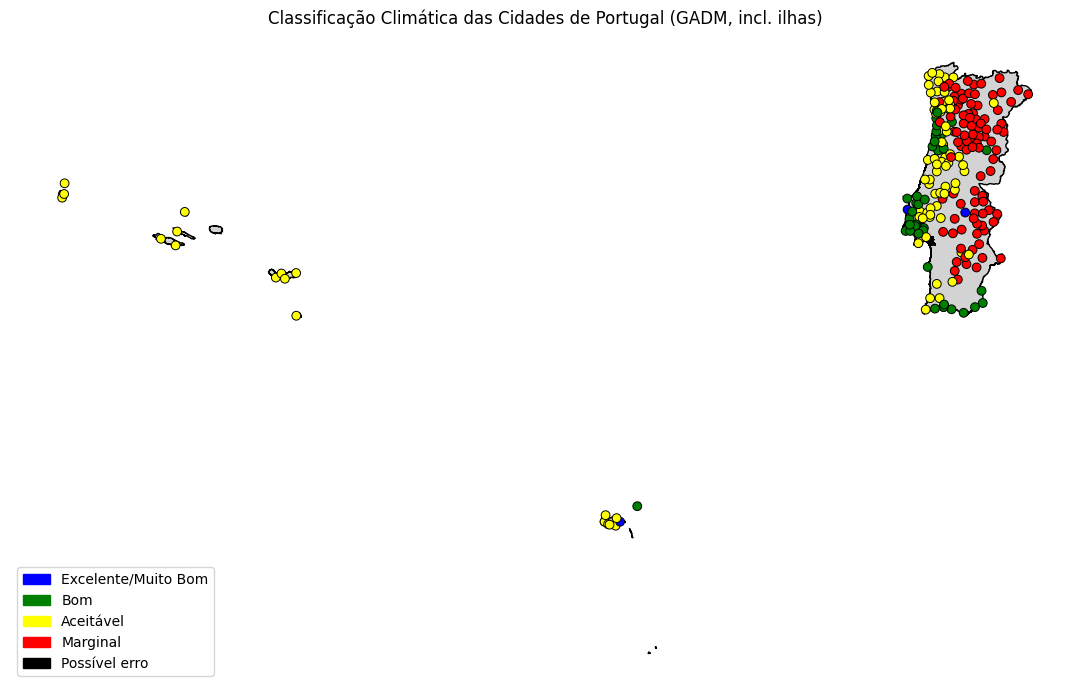

In [ ]:

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Caminho do shapefile do GADM (Portugal)

shapefile_path = '..\\..\\Bases\\Geocoding\\files\\Gadm - Portugal - Shape\\gadm41_PRT_0.shp' 
# 1. Carrega e limpa o shapefile
portugal = gpd.read_file(shapefile_path)

# Corrige eventuais geometrias inválidas
portugal['geometry'] = portugal['geometry'].buffer(0)
# Remove linhas sem geometria válida
portugal = portugal[portugal.is_valid & ~portugal.is_empty]

if portugal.empty:
    raise ValueError('O shapefile está vazio ou inválido!')

# Faz a união de todos os polígonos do shape (Continente + Madeira + Açores)
portugal_union = portugal.geometry.unary_union

# 2. Converte sua tabela de cidades para GeoDataFrame
# ranking_geo deve ter as colunas 'municipio', 'latitude', 'longitude', 'classificacao_geral'
cores = {
    'Excelente': 'blue',
    'Muito Bom': 'blue',
    'Bom': 'green',
    'Aceitável': 'yellow',
    'Marginal': 'red'
}
ranking_geo['cor'] = ranking_geo['classificacao_geral'].map(cores)

gdf = gpd.GeoDataFrame(
    ranking_geo,
    geometry=gpd.points_from_xy(ranking_geo.longitude, ranking_geo.latitude),
    crs="EPSG:4326"
)

# 3. Marque pontos dentro e fora de Portugal (incluindo ilhas)
gdf['dentro_portugal'] = gdf.geometry.apply(portugal_union.covers)

# Separe pontos
dentro_portugal = gdf[gdf['dentro_portugal']]
fora_portugal = gdf[~gdf['dentro_portugal']]

# 4. Mostre os possíveis erros
if not fora_portugal.empty:
    print('Cidades possivelmente com coordenadas erradas:')
    print(fora_portugal[['municipio', 'latitude', 'longitude']])
else:
    print('Todas as cidades estão corretamente localizadas em Portugal.')

# 5. Plot bonito!
fig, ax = plt.subplots(figsize=(11, 13))
portugal.plot(ax=ax, color='lightgrey', edgecolor='black', zorder=0)
dentro_portugal.plot(
    ax=ax, color=dentro_portugal['cor'], markersize=40,
    marker='o', edgecolor='black', linewidth=0.7, zorder=2
)
if not fora_portugal.empty:
    fora_portugal.plot(
        ax=ax, color='black', markersize=70, marker='x',
        label='Possível erro', zorder=3
    )

patches = [
    mpatches.Patch(color='blue', label='Excelente/Muito Bom'),
    mpatches.Patch(color='green', label='Bom'),
    mpatches.Patch(color='yellow', label='Aceitável'),
    mpatches.Patch(color='red', label='Marginal'),
    mpatches.Patch(color='black', label='Possível erro')
]
plt.legend(handles=patches, loc='lower left', fontsize=10)
plt.title('Classificação Climática das Cidades de Portugal (GADM, incl. ilhas)')
plt.axis('off')
plt.tight_layout()
plt.show()
